In [1]:
import numpy as np
from matplotlib import pyplot as plt

import glob
from astropy.io import fits

%matplotlib inline
#%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

In [2]:
def open_fits(filepath, plot):
    file_temp = fits.open(filepath)
    file = file_temp[0].data
    file_temp.close()
    if plot == True:
        plt.imshow(file, clim=np.quantile(file, [0.01, 0.99]), cmap='gnuplot2', origin='lower')
        plt.colorbar(fraction=0.0375, pad=0.02);
    return file

# Removing the sky

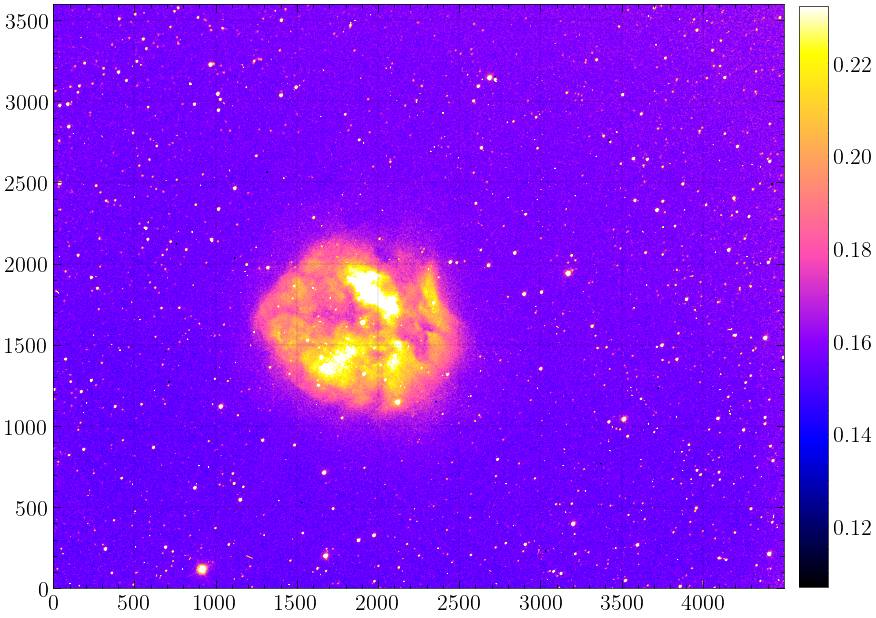

In [3]:
science_20241028_Ha_1 = open_fits(filepath='Data/science_20241028_Ha_1.fits', plot=True)

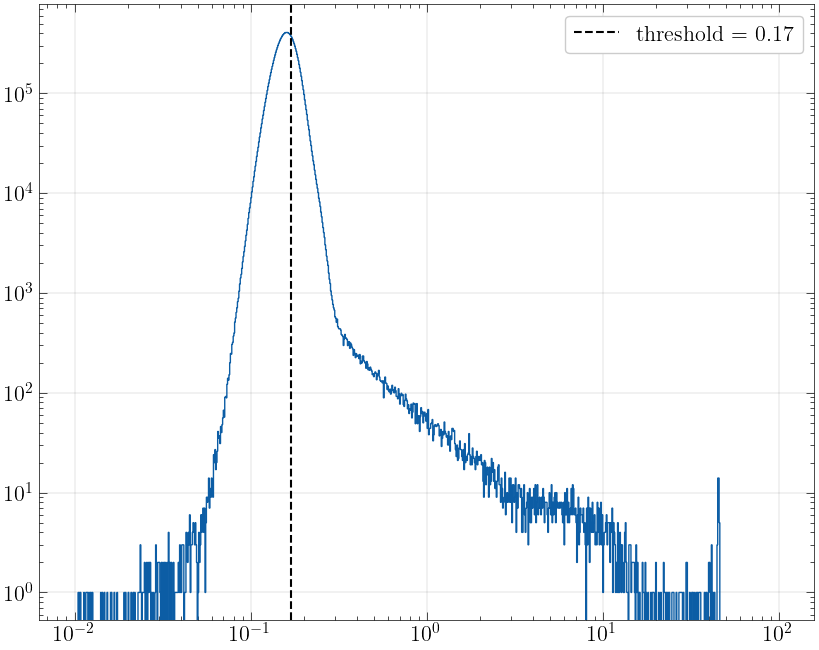

In [4]:
threshold = 0.17

plt.hist(science_20241028_Ha_1.flatten(), bins=np.logspace(start=-2, stop=2, num=1000), histtype='step');
plt.axvline(threshold, ls='--', color='k', label=f'threshold = {threshold}')
plt.xscale('log')
plt.yscale('log')
plt.legend();

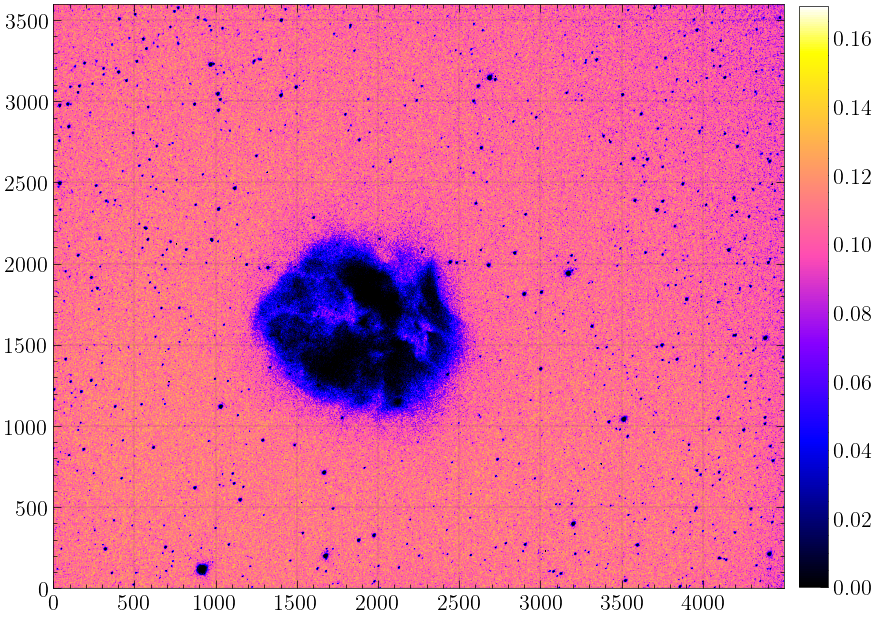

In [5]:
science_20241028_Ha_1_masked = science_20241028_Ha_1.copy()
science_20241028_Ha_1_masked[science_20241028_Ha_1_masked > threshold] = 0

plt.imshow(science_20241028_Ha_1_masked, clim=np.quantile(science_20241028_Ha_1_masked, [0.01, 0.99]), cmap='gnuplot2', origin='lower')
plt.colorbar(fraction=0.0375, pad=0.02);

In [11]:
from scipy.optimize import curve_fit

science_20241028_Ha_1_masked[science_20241028_Ha_1_masked==0] = np.NaN
valid_mask = ~np.isnan(science_20241028_Ha_1_masked)

# Generate coordinate grids
y, x = np.indices(science_20241028_Ha_1_masked.shape)

# Flatten and filter out NaN values
x_flat = x[~np.isnan(science_20241028_Ha_1_masked)]
y_flat = y[~np.isnan(science_20241028_Ha_1_masked)]
z_flat = science_20241028_Ha_1_masked[~np.isnan(science_20241028_Ha_1_masked)]

# Define a 2D polynomial function to fit (e.g., 2nd degree)
def poly2d(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*x*y + f*y**2

# Fit the polynomial to the non-NaN data points
popt, _ = curve_fit(poly2d, (x_flat, y_flat), z_flat)

# Generate the fitted surface on the full grid
fitted_surface = poly2d((x, y), *popt)

# Fitted surface now has the polynomial values over the entire science_20241028_Ha_1_masked
# You can replace NaNs in the original science_20241028_Ha_1_masked with the fitted values
science_20241028_Ha_1_masked_fitted = np.where(np.isnan(science_20241028_Ha_1_masked), fitted_surface, science_20241028_Ha_1_masked)

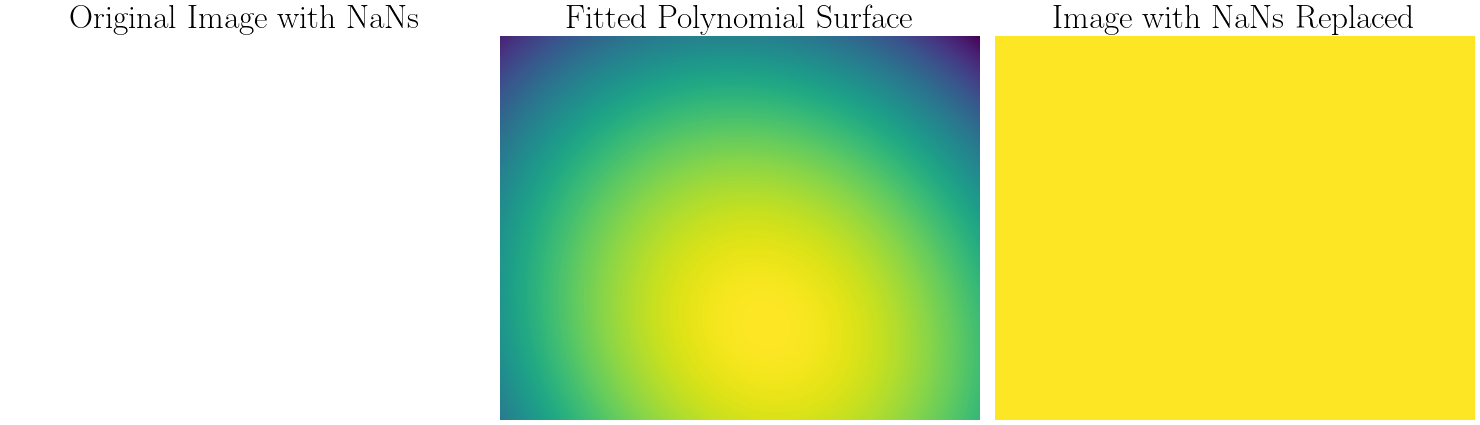

In [13]:
# Plot the original image, fitted surface, and the result after replacing NaNs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image with NaNs
axes[0].imshow(science_20241028_Ha_1_masked, cmap='viridis')
axes[0].set_title("Original Image with NaNs")
axes[0].axis('off')

# Fitted polynomial surface
axes[1].imshow(fitted_surface, cmap='viridis')
axes[1].set_title("Fitted Polynomial Surface")
axes[1].axis('off')

# Final image after replacing NaNs
axes[2].imshow(science_20241028_Ha_1_masked_fitted, cmap='viridis')
axes[2].set_title("Image with NaNs Replaced")
axes[2].axis('off')

plt.tight_layout()
plt.show()